# PyPSA Beispiel 3

Sie besitzen einen kleinen landwirtschaftlichen Betrieb mit Gewerbe und mehrere Wohneinheiten. Im Zuge Ihrer Bastelarbeiten konnten Sie eine alte Windturbine aus dem Jahr 1993 reaktivieren, eine Nordex N27 150 mit einer Nabenhöhe von 35 m. Diese wollen Sie neben dem Netzbezug zur Deckung der Stromlast nutzen. Darüber hinaus dürfen Sie ebenfalls mit einer Vergütung von 7,35 ct/kWh einspeisen.
Ihre Wärmelast wird derzeit zentral mit einem Gaskessel gedeckt. 
Ermitteln Sie die mögliche Windeinspeisung an einem beliebigen Ort (z.B. Wohnort oder Geburtsort) und binden Sie diese Daten mit ein.

Importieren Sie zunächst die notwendigen Bibliotheken

In [1]:
import pandas as pd
import numpy as np
import pypsa

 Der Strom-, sowie der thermische Lastgang sind in der Datei "data_pypsa_03.csv" gespeichert. Lesen Sie diese mit pandas ein. Lesen Sie auch ihre Winddaten ein.

In [2]:
df_data = pd.read_csv('data_pypsa_03.csv')
df_wind = pd.read_csv("wind_Nordex N27_150.csv", sep = ',', decimal = '.', usecols = ["electricity in kw"])

<Axes: >

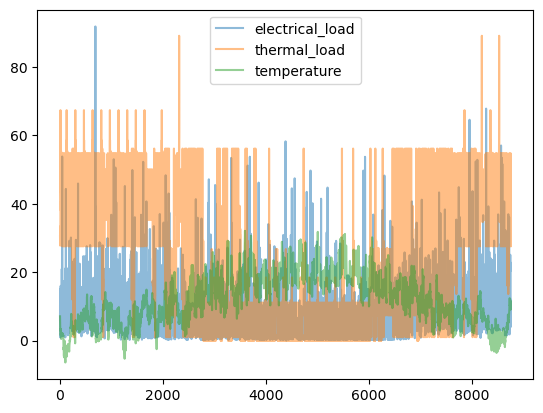

In [3]:
df_data.plot(alpha = 0.5)

## a. Basissytem

Implementieren Sie zunächst das elektrische System. Anschließend implementieren Sie ebenfalls das thermische.

In [4]:
#Elektrisches System
wind_p_nom = 150 #kW
wind_p_pu = df_wind['electricity in kw'] / wind_p_nom # Lastgang in p.u.

electricity_load    = df_data['electrical_load']

electricity_rate    =   0.409  #€/kWh
infeed_rate         =  -0.0735 #€/kWh Höchstwert für Windenergie-Anlagen bis 10kWp
grid_co2_emissions  =   0.380  #kg CO2_e/kWh

# Thermisches System
thermal_load = df_data['thermal_load']

boiler_p_nom = np.inf
boiler_eff = 0.95

thermal_store_e_nom = 200 #kWh (entsprich bei einer T-Spreizung von 45K ca. 3800L)
gas_rate = 0.123 #€/kWh_gas
gas_co2_emissions = 0.244 #kg CO2_e/kWh


In [5]:
network = pypsa.Network()
network.set_snapshots(range(8760))

#Elektrisches System 
network.add('Bus', name = 'electricity_grid')
network.add('Bus', name = 'electricity_infeed')

network.add('Carrier', name = 'grid_electricity', co2_emissions = grid_co2_emissions)

network.add('Generator', name = 'Wind', bus = 'electricity_infeed', 
            p_nom = wind_p_nom, p_max_pu = wind_p_pu)
network.add('Generator', name = 'Grid', bus = 'electricity_grid', 
            p_nom = np.inf, marginal_cost = electricity_rate,
            carrier = 'grid_electricity')
network.add('Generator', name = 'Infeed', bus = 'electricity_infeed',
            p_nom = df_wind["electricity in kw"].max(), marginal_cost = infeed_rate, sign = -1)

network.add('Load', name = 'Electrical_Load', bus = 'electricity_grid', 
            p_set = electricity_load)

network.add('Link', name = 'electricity_link', bus0 = 'electricity_infeed', 
            bus1 = 'electricity_grid', p_nom = df_wind["electricity in kw"].max())

#Thermisches System

network.add('Bus', name = 'thermal')
network.add('Bus', name = 'gas_bus')

network.add('Carrier', name = 'gas', co2_emissions = gas_co2_emissions)

network.add('Generator', name = 'Gas', bus = 'gas_bus', p_nom = np.inf, 
            marginal_cost = gas_rate, carrier = 'gas')

network.add('Load', name = 'Thermal_Load', bus = 'thermal', p_set = thermal_load)

network.add('Link', name = 'boiler', bus0 = 'gas_bus', bus1 = 'thermal', 
            p_nom = boiler_p_nom, efficiency = boiler_eff)


Index(['boiler'], dtype='object')

Optimieren Sie das Netzwerk 

In [6]:
network.optimize(solver_name = 'gurobi', threads = 1, method = 1)

Index(['electricity_link', 'boiler'], dtype='object', name='Link')
Index(['electricity_grid', 'electricity_infeed', 'thermal', 'gas_bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.96it/s]
INFO:linopy.io: Writing time: 0.58s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-9vmp13ga.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-9vmp13ga.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 113880 rows, 52560 columns, 148920 nonzeros


INFO:gurobipy:obj: 113880 rows, 52560 columns, 148920 nonzeros


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Set parameter Method to value 1


INFO:gurobipy:Set parameter Method to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  1


INFO:gurobipy:Method  1


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 113880 rows, 52560 columns and 148920 nonzeros


INFO:gurobipy:Optimize a model with 113880 rows, 52560 columns and 148920 nonzeros


Model fingerprint: 0xf939a7df


INFO:gurobipy:Model fingerprint: 0xf939a7df


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [7e-02, 4e-01]


INFO:gurobipy:  Objective range  [7e-02, 4e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [8e-03, 1e+02]


INFO:gurobipy:  RHS range        [8e-03, 1e+02]


Presolve removed 113880 rows and 52560 columns


INFO:gurobipy:Presolve removed 113880 rows and 52560 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolve: All rows and columns removed


INFO:gurobipy:Presolve: All rows and columns removed


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8326420e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       0    1.8326420e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 0 iterations and 0.15 seconds (0.07 work units)


INFO:gurobipy:Solved in 0 iterations and 0.15 seconds (0.07 work units)


Optimal objective  1.832641953e+04


INFO:gurobipy:Optimal objective  1.832641953e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52560 primals, 113880 duals
Objective: 1.83e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


('ok', 'optimal')

Lassen Sie sich mittels .statistics() die jährlichen Kosten ausgeben. und ermitteln Sie die THG-Emissionen.

In [7]:
operational_cost_1 = network.statistics()["Operational Expenditure"].sum()
print("Jährliche Betriebskosten:", round(operational_cost_1,2), "€/a")

Jährliche Betriebskosten: 18326.42 €/a


In [8]:
co2_1 = network.generators_t.p.sum()["Grid"] * grid_co2_emissions + network.generators_t.p.sum()["Gas"] * gas_co2_emissions
print("THG-Emissionen:", round(co2_1/1000,2),"t")

THG-Emissionen: 52.78 t


## b. BHKW

Nun wollen Sie prüfen, ob die Anschaffung eines BHKW‘s ökonomisch sinnvoll ist. 
Hierzu implementieren Sie auch das thermische System, welches aus einem Gasanschluss, einem Gaskessel, sowie der thermischen Last besteht. Ermitteln Sie die ökonomisch optimale Auslegung des BHKW‘s, sowie die jährlichen Strom- und Gaskosten. 

Erweitern Sie das System um das BHKW

In [9]:
bhkw_eff_el = 0.35
bhkw_eff_th = 0.55

interest_rate = 0.02
bhkw_invest = 1000 * bhkw_eff_el #€/kW_el * (kW_el/kW_gas) =  €/kW_gas
bhkw_lifespan = 20 #Jahre
bhkw_annuity = bhkw_invest*((1+interest_rate)**bhkw_lifespan)*interest_rate/((1+interest_rate)**bhkw_lifespan-1)
 

In [10]:
network.add('Link', name = 'bhkw', bus0 = 'gas_bus', bus1 = 'electricity_grid', 
            bus2 = 'thermal', p_nom_extendable = True, capital_cost = bhkw_annuity,
            efficiency = bhkw_eff_el, efficiency2 = bhkw_eff_th)

Index(['bhkw'], dtype='object')

Optimieren Sie das Netzwerk

In [11]:
network.optimize(solver_name='gurobi', method = 1, threads =1)

Index(['electricity_link', 'boiler', 'bhkw'], dtype='object', name='Link')
Index(['electricity_grid', 'electricity_infeed', 'thermal', 'gas_bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 1
 - threads: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 25.35it/s]
INFO:linopy.io: Writing time: 0.78s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-se47u3eh.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-se47u3eh.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 131401 rows, 61321 columns, 201481 nonzeros


INFO:gurobipy:obj: 131401 rows, 61321 columns, 201481 nonzeros


Set parameter Method to value 1


INFO:gurobipy:Set parameter Method to value 1


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  1


INFO:gurobipy:Method  1


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 131401 rows, 61321 columns and 201481 nonzeros


INFO:gurobipy:Optimize a model with 131401 rows, 61321 columns and 201481 nonzeros


Model fingerprint: 0xdbbada28


INFO:gurobipy:Model fingerprint: 0xdbbada28


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-01, 1e+00]


INFO:gurobipy:  Matrix range     [3e-01, 1e+00]


  Objective range  [7e-02, 2e+01]


INFO:gurobipy:  Objective range  [7e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [8e-03, 1e+02]


INFO:gurobipy:  RHS range        [8e-03, 1e+02]


Presolve removed 128723 rows and 57445 columns


INFO:gurobipy:Presolve removed 128723 rows and 57445 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 2678 rows, 3876 columns, 6553 nonzeros


INFO:gurobipy:Presolved: 2678 rows, 3876 columns, 6553 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6355973e+04   3.497062e+03   0.000000e+00      0s


INFO:gurobipy:       0    1.6355973e+04   3.497062e+03   0.000000e+00      0s


    1604    1.7328388e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1604    1.7328388e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1604 iterations and 0.25 seconds (0.16 work units)


INFO:gurobipy:Solved in 1604 iterations and 0.25 seconds (0.16 work units)


Optimal objective  1.732838783e+04


INFO:gurobipy:Optimal objective  1.732838783e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61321 primals, 131401 duals
Objective: 1.73e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Lassen Sie sich die Größe des BHKWs ausgeben und berechnen Sie dessen Investitionskosten 

In [12]:
bhkw_p_nom_opt = network.links.p_nom_opt.bhkw
bhkw_costs = bhkw_p_nom_opt * bhkw_annuity * bhkw_lifespan
print("BHKW:")
print("Optimale Leistung:", round(bhkw_p_nom_opt,2), "kW")
print("Gesamtkapitalkosten:", round(bhkw_costs,2),"€")

BHKW:
Optimale Leistung: 24.19 kW
Gesamtkapitalkosten: 10357.68 €


Berechnen Sie erneut die jährlichen Kosten. Zudem berechnen Sie die Ersparnis gegenüber dem Basissystem und die Amortisationszeit des BHKWs

In [13]:
operational_cost_2 = network.statistics()["Operational Expenditure"].sum() + network.statistics()["Capital Expenditure"].sum()
print("Jährliche Kosten:", round(operational_cost_2,2), "€/a")

ersparnis = operational_cost_1 - operational_cost_2 
print("Ersparnis:", round(ersparnis,2),"€")
print("Armotisationszeit:", round(bhkw_costs/ersparnis,2),"Jahre")

Jährliche Kosten: 17328.39 €/a
Ersparnis: 998.03 €
Armotisationszeit: 10.38 Jahre


Wie hoch fällt die Eigenverbrauchsquote der Windenerieanlage aus?

## c. Wärmepumpe

Sie wollen die Eigenverbrauchsquote ihrere Windenergieanlage erhöhen und wollen daher eine Wärmepumpe in ihr Energiesystem integrieren um auch die Wärmelast über den durch Wind erzeugten Strom bedienen zu können. Implementieren Sie hierzu eine Wärmepumpe. Beachten Sie die Temperaturabhängigkeit des COPs, sowie der elektrischen Leistungsaufnahme einer Wärmepumpe.


Im Folgenden wird anhand des Datenblatts der Wärmepumpe die Leistungszahl (COP) und die elektrische Leistungsaufnahme in Abhängikeit der Außentemperatur interpoliert. Die Daten für die Wärmepumpe basieren auf der Viessmann VITOCAL 252-A (Typ AWOT-E-AC-AF 251.A13) mit einer elektrischen Nennleistung nach DIN 14511 (A7/W35) von 1,56 kW. <br>
Quelle: https://community.viessmann.de/viessmann/attachments/viessmann/customers-heatpump-hybrid/109104/1/pa-viessmann-Vitocal-250-A-252-A-Monoblock-2,6-bis-13,4kW-2%20(1).pdf

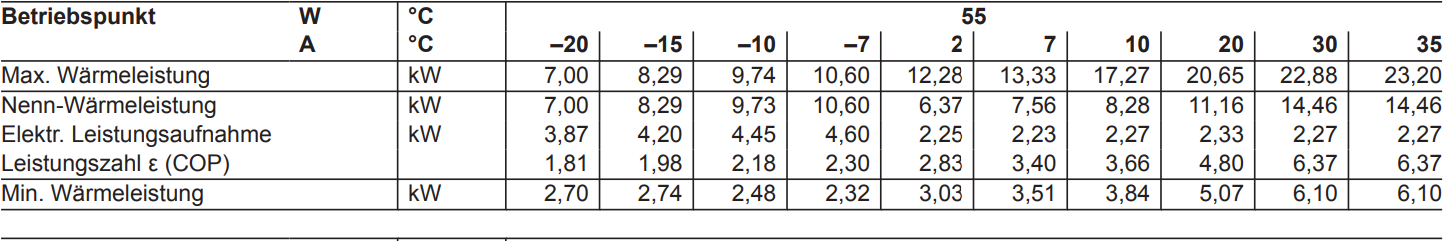

In [14]:
T_VL        =   55 #°C
temp        =   [ -20, -15, -10,  -7,   2,   7,  10,  20,  30,  35] #°C
el_power    =   [3.87,4.20,4.45,4.60,2.25,2.23,2.27,2.33,2.27,2.27] #kW
cop         =   [1.81,1.98,2.18,2.30,2.83,3.40,3.66,4.80,6.37,6.37]
hp_p_nom    =   1.56 #kW

Berechnen Sie zunächst den COP in Abhängigkeit der Außentemperatur. Verwenden Sie als erste Näherung dazu die Formel für den idealen Carnot-Wirkungsgrad [1].

Der COP soll als neue Spalte dem Dataframe mit den Lastgängen hinzugefügt werden.

[1] https://de.wikipedia.org/wiki/Carnot-Wirkungsgrad

Anschließend interpolieren Sie den COP aus der oben abgebildeten Tabelle linear. Sie können die numpy Methode np.interp dazu nutzen. Auch diese Berechnung soll dem Dataframe als Spalte hinzugefügt werden. Vergleichen Sie die beiden Spalten anschließend in einem Plot. Hierbei bietet es sich an die Werte über die Temperatur aufzutragen. Nutzen Sie hierzu '.sort_values(['temperature']).plot(x='temperature')'

In [15]:
df_data['COP_Carnot'] = (T_VL + 273.15)/((T_VL + 273.15) - (df_data['temperature'] + 273.15))
df_data['COP_interp'] = np.interp(df_data['temperature'], temp, cop)
df_data["el_p_pu"]  = (np.interp(df_data['temperature'],temp,el_power))/hp_p_nom

<Axes: xlabel='temperature'>

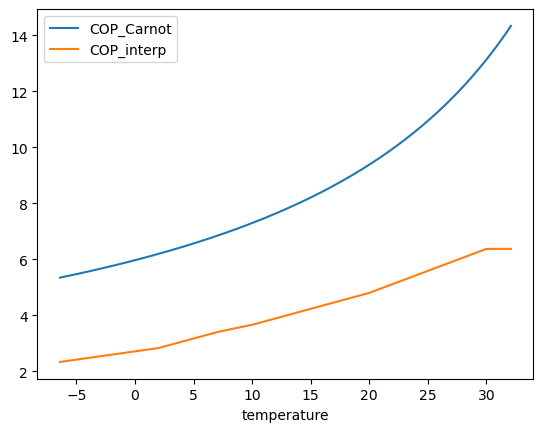

In [16]:
df_data.loc[:,["temperature","COP_Carnot","COP_interp"]].sort_values(['temperature']).plot(x = 'temperature')

Implementieren Sie die Wärmepumpe

In [17]:
heatpump_eff        = df_data["COP_interp"] 
heatpump_p_max_pu   = df_data["el_p_pu"] 
heatpump_invest = 960 #€/kWel
heatpump_lifespan = 20 #Jahre
heatpump_annuity    = heatpump_invest*((1+interest_rate)**heatpump_lifespan)*interest_rate/((1+interest_rate)**heatpump_lifespan-1)

In [18]:
network.add('Link', name = 'heatpump', bus0 = 'electricity_grid', bus1 = 'thermal', 
            p_nom_extendable = True, capital_cost = heatpump_annuity, 
            p_max_pu = heatpump_p_max_pu, efficiency = heatpump_eff)

Index(['heatpump'], dtype='object')

Optimieren Sie das Netzwerk



In [19]:
network.optimize(solver_name = 'gurobi', method = 1, threads = 1)

Index(['electricity_link', 'boiler', 'bhkw', 'heatpump'], dtype='object', name='Link')
Index(['electricity_grid', 'electricity_infeed', 'thermal', 'gas_bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 1
 - threads: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 23.21it/s]
INFO:linopy.io: Writing time: 0.91s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-pmjr97fo.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-pmjr97fo.lp


Reading time = 0.28 seconds


INFO:gurobipy:Reading time = 0.28 seconds


obj: 148922 rows, 70082 columns, 245282 nonzeros


INFO:gurobipy:obj: 148922 rows, 70082 columns, 245282 nonzeros


Set parameter Method to value 1


INFO:gurobipy:Set parameter Method to value 1


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  1


INFO:gurobipy:Method  1


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 148922 rows, 70082 columns and 245282 nonzeros


INFO:gurobipy:Optimize a model with 148922 rows, 70082 columns and 245282 nonzeros


Model fingerprint: 0x9d8c5e11


INFO:gurobipy:Model fingerprint: 0x9d8c5e11


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-01, 6e+00]


INFO:gurobipy:  Matrix range     [3e-01, 6e+00]


  Objective range  [7e-02, 1e+03]


INFO:gurobipy:  Objective range  [7e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [8e-03, 1e+02]


INFO:gurobipy:  RHS range        [8e-03, 1e+02]


Presolve removed 120845 rows and 35195 columns


INFO:gurobipy:Presolve removed 120845 rows and 35195 columns


Presolve time: 0.32s


INFO:gurobipy:Presolve time: 0.32s


Presolved: 12530 rows, 22199 columns, 40162 nonzeros


INFO:gurobipy:Presolved: 12530 rows, 22199 columns, 40162 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.2649715e+34   2.802994e+33   1.264971e+04      0s


INFO:gurobipy:       0    1.2649715e+34   2.802994e+33   1.264971e+04      0s


   21759    9.6424398e+03   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   21759    9.6424398e+03   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 21759 iterations and 3.35 seconds (4.33 work units)


INFO:gurobipy:Solved in 21759 iterations and 3.35 seconds (4.33 work units)


Optimal objective  9.642439830e+03


INFO:gurobipy:Optimal objective  9.642439830e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70082 primals, 148922 duals
Objective: 9.64e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Geben Sie mit den folgenden Funktionen die optimale Größe des BHKWs und der Wärmepumpe aus: <br>
network.links.p_nom_opt 

In [20]:
network.links.p_nom_opt 

Link
electricity_link    137.484000
boiler                     inf
bhkw                 38.149919
heatpump              6.877703
Name: p_nom_opt, dtype: float64

Bestimmen Sie erneut die jährlichen Kosten

In [21]:
operational_cost_3 = network.statistics()["Operational Expenditure"].sum() + network.statistics()["Capital Expenditure"].sum()
print("Jährliche Kosten:", round(operational_cost_3,2), "€/a")

Jährliche Kosten: 9642.44 €/a


In [22]:
heatpump_p_nom_opt = network.links.p_nom_opt.heatpump
heatpump_costs = heatpump_p_nom_opt * heatpump_annuity * heatpump_lifespan
print("Wärmepumpe")
print("Optimale Leistung:",round(heatpump_p_nom_opt,2),"kW")
print("Investitionskosten:", round(heatpump_costs,2),"€")

Wärmepumpe
Optimale Leistung: 6.88 kW
Investitionskosten: 8075.86 €


In [23]:
ersparnis_2 = operational_cost_2 - operational_cost_3 
print("Ersparnis:", round(ersparnis_2,2),"€/a")
print("Armotisationszeit:", round(heatpump_costs/ersparnis_2,2),"Jahre")

Ersparnis: 7685.95 €/a
Armotisationszeit: 1.05 Jahre


Wie viel THG-Emissionen kann gegenüber dem Basissystem eingespart werden?

In [24]:
co2_2 = network.generators_t.p.sum()["Grid"] * grid_co2_emissions + network.generators_t.p.sum()["Gas"] * gas_co2_emissions
co2_reduktion = co2_1 - co2_2
print("THG-Emissionen:", round(co2_2/1000,2),"t")
print("CO2-Reduktion:")
print(round(co2_reduktion/1000,2),"t")
print(round(co2_reduktion/co2_1*100,2),"%")

THG-Emissionen: 18.79 t
CO2-Reduktion:
33.99 t
64.4 %


## d. CO2 - Limit

Fügen Sie nun eine Global Constraint hinzu um die THG-Emissionen 70%, 90% und 100% gegenüber dem Basissystem zu senken. Wie groß fallen die Komponenten und die jährlichen Kosten aus? 

In [47]:
network.add('GlobalConstraint', name = 'co2-limt', 
            carrier_attribute = 'co2_emissions', sense = '<=', overwrite=True,
            constant = co2_1 * 0.3)

Index(['co2-limt'], dtype='object')

In [32]:
network.optimize(solver_name='gurobi', method = 1, threads = 1)

Index(['electricity_link', 'boiler', 'bhkw', 'heatpump'], dtype='object', name='Link')
Index(['electricity_grid', 'electricity_infeed', 'thermal', 'gas_bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 1
 - threads: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 22.41it/s]
INFO:linopy.io: Writing time: 1.41s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-hfti8716.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-hfti8716.lp


Reading time = 0.28 seconds


INFO:gurobipy:Reading time = 0.28 seconds


obj: 148923 rows, 70082 columns, 262802 nonzeros


INFO:gurobipy:obj: 148923 rows, 70082 columns, 262802 nonzeros


Set parameter Method to value 1


INFO:gurobipy:Set parameter Method to value 1


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  1


INFO:gurobipy:Method  1


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 148923 rows, 70082 columns and 262802 nonzeros


INFO:gurobipy:Optimize a model with 148923 rows, 70082 columns and 262802 nonzeros


Model fingerprint: 0x214c04bc


INFO:gurobipy:Model fingerprint: 0x214c04bc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-01, 6e+00]


INFO:gurobipy:  Matrix range     [2e-01, 6e+00]


  Objective range  [7e-02, 1e+03]


INFO:gurobipy:  Objective range  [7e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [8e-03, 2e+04]


INFO:gurobipy:  RHS range        [8e-03, 2e+04]


Presolve removed 120838 rows and 35188 columns


INFO:gurobipy:Presolve removed 120838 rows and 35188 columns


Presolve time: 0.27s


INFO:gurobipy:Presolve time: 0.27s


Presolved: 28085 rows, 34894 columns, 98152 nonzeros


INFO:gurobipy:Presolved: 28085 rows, 34894 columns, 98152 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0   -1.1913967e+04   4.649482e+04   0.000000e+00      0s


INFO:gurobipy:       0   -1.1913967e+04   4.649482e+04   0.000000e+00      0s


   10174    9.9819662e+03   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   10174    9.9819662e+03   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 10174 iterations and 3.96 seconds (5.01 work units)


INFO:gurobipy:Solved in 10174 iterations and 3.96 seconds (5.01 work units)


Optimal objective  9.981966184e+03


INFO:gurobipy:Optimal objective  9.981966184e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70082 primals, 148923 duals
Objective: 9.98e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [33]:
network.links.p_nom_opt

Link
electricity_link    137.484000
boiler                     inf
bhkw                 37.219235
heatpump              8.451536
Name: p_nom_opt, dtype: float64

Reduzieren Sie das Limit auf 90% der Emissionen des Basissystems und führen Sie die Optimierung erneut durch. Was fällt Ihnen auf?

Fügen Sie einen Batteriespeicher dem elektrischen System hinzu, sodass eine weitere THG-Reduktion möglich ist. Die Lade-/Entladeleistung des Speichers soll dabei halb so groß sein, wie seine Kapazität. Die spezifischen Investkosten liegen bei 800 €/kWh. Gehen Sie von einer Lebensdauer von 15 Jahren aus. <br>
(Hinweis: nutzen Sie bei einer StorageUnit das Attribut 'cyclic_state_of_charge', bei einem Store 'e_cylcic')

In [34]:
battery_invest = 800 #€/kWh
battery_lifetime = 15 #Jahre
battery_annuity = battery_invest*((1+interest_rate)**battery_lifetime)*interest_rate/((1+interest_rate)**battery_lifetime-1)

In [37]:
network.add('StorageUnit', name = 'Battery', bus = "electricity_grid", 
            p_nom_extendable = True, max_hours = 2, overwrite= True,
            capital_cost = battery_annuity / 2, cyclic_state_of_charge = True)

Index(['Battery'], dtype='object')

In [38]:
network.optimize(solver_name = 'gurobi', method = 1, threads = 1)

Index(['electricity_link', 'boiler', 'bhkw', 'heatpump'], dtype='object', name='Link')
Index(['electricity_grid', 'electricity_infeed', 'thermal', 'gas_bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 1
 - threads: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 22.59it/s]
INFO:linopy.io: Writing time: 1.54s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-p1bmsdis.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-p1bmsdis.lp


Reading time = 0.64 seconds


INFO:gurobipy:Reading time = 0.64 seconds


obj: 210244 rows, 96363 columns, 394203 nonzeros


INFO:gurobipy:obj: 210244 rows, 96363 columns, 394203 nonzeros


Set parameter Method to value 1


INFO:gurobipy:Set parameter Method to value 1


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  1


INFO:gurobipy:Method  1


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 210244 rows, 96363 columns and 394203 nonzeros


INFO:gurobipy:Optimize a model with 210244 rows, 96363 columns and 394203 nonzeros


Model fingerprint: 0xdb31b8a0


INFO:gurobipy:Model fingerprint: 0xdb31b8a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-01, 6e+00]


INFO:gurobipy:  Matrix range     [2e-01, 6e+00]


  Objective range  [7e-02, 1e+03]


INFO:gurobipy:  Objective range  [7e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [8e-03, 2e+04]


INFO:gurobipy:  RHS range        [8e-03, 2e+04]


Presolve removed 145167 rows and 31284 columns


INFO:gurobipy:Presolve removed 145167 rows and 31284 columns


Presolve time: 0.28s


INFO:gurobipy:Presolve time: 0.28s


Presolved: 65077 rows, 65079 columns, 209412 nonzeros


INFO:gurobipy:Presolved: 65077 rows, 65079 columns, 209412 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0   -1.4441525e+04   5.350089e+04   0.000000e+00      0s


INFO:gurobipy:       0   -1.4441525e+04   5.350089e+04   0.000000e+00      0s


   22875    5.5133061e+03   2.428211e+05   0.000000e+00      5s


INFO:gurobipy:   22875    5.5133061e+03   2.428211e+05   0.000000e+00      5s


   33066    8.1042007e+03   5.029538e+06   0.000000e+00     10s


INFO:gurobipy:   33066    8.1042007e+03   5.029538e+06   0.000000e+00     10s


   36716    8.4393145e+03   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:   36716    8.4393145e+03   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 36716 iterations and 13.21 seconds (16.25 work units)


INFO:gurobipy:Solved in 36716 iterations and 13.21 seconds (16.25 work units)


Optimal objective  8.439314458e+03


INFO:gurobipy:Optimal objective  8.439314458e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96363 primals, 210244 duals
Objective: 8.44e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [39]:
network.storage_units.p_nom_opt

StorageUnit
Battery    27.562276
Name: p_nom_opt, dtype: float64

Lassen Sie nun keine THG-Emissionen zu!

In [49]:
network.global_constraints.loc['co2-limt', 'constant'] = 0

In [50]:
network.global_constraints.loc['co2-limt', 'constant']

0.0

In [51]:
network.optimize(solver_name = 'gurobi', method = 1, threads = 1)

Index(['electricity_link', 'boiler', 'bhkw', 'heatpump'], dtype='object', name='Link')
Index(['electricity_grid', 'electricity_infeed', 'thermal', 'gas_bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 1
 - threads: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.93it/s]
INFO:linopy.io: Writing time: 1.31s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-tyxrwm52.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-tyxrwm52.lp


Reading time = 0.41 seconds


INFO:gurobipy:Reading time = 0.41 seconds


obj: 210244 rows, 96363 columns, 394203 nonzeros


INFO:gurobipy:obj: 210244 rows, 96363 columns, 394203 nonzeros


Set parameter Method to value 1


INFO:gurobipy:Set parameter Method to value 1


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  1


INFO:gurobipy:Method  1


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 210244 rows, 96363 columns and 394203 nonzeros


INFO:gurobipy:Optimize a model with 210244 rows, 96363 columns and 394203 nonzeros


Model fingerprint: 0x5ed52d81


INFO:gurobipy:Model fingerprint: 0x5ed52d81


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-01, 6e+00]


INFO:gurobipy:  Matrix range     [2e-01, 6e+00]


  Objective range  [7e-02, 1e+03]


INFO:gurobipy:  Objective range  [7e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [8e-03, 1e+02]


INFO:gurobipy:  RHS range        [8e-03, 1e+02]


Presolve removed 178953 rows and 70675 columns


INFO:gurobipy:Presolve removed 178953 rows and 70675 columns


Presolve time: 0.53s


INFO:gurobipy:Presolve time: 0.53s


Presolved: 31291 rows, 25688 columns, 96800 nonzeros


INFO:gurobipy:Presolved: 31291 rows, 25688 columns, 96800 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.7658436e+03   7.059824e+04   0.000000e+00      1s


INFO:gurobipy:       0    9.7658436e+03   7.059824e+04   0.000000e+00      1s


   13430    6.9173303e+04   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13430    6.9173303e+04   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13430 iterations and 1.02 seconds (0.76 work units)


INFO:gurobipy:Solved in 13430 iterations and 1.02 seconds (0.76 work units)


Optimal objective  6.917330322e+04


INFO:gurobipy:Optimal objective  6.917330322e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96363 primals, 210244 duals
Objective: 6.92e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [52]:
print("Jährliche Kosten:", round(network.statistics()["Operational Expenditure"].sum() + network.statistics()["Capital Expenditure"].sum(),2), "€/a")

Jährliche Kosten: 69173.3 €/a


In [53]:
network.storage_units.p_nom_opt

StorageUnit
Battery    1829.288245
Name: p_nom_opt, dtype: float64